In [1]:
import math
import os
import gc
import sys
import time
from pathlib import Path
from tqdm.notebook import tqdm

from numba import jit, njit

BASE_DIR = '/home/dmitry/projects/dfdc'
SRC_DIR = os.path.join(BASE_DIR, 'src')
DATA_DIR = os.path.join(BASE_DIR, 'data/dfdc-videos')

sys.path.insert(0, SRC_DIR)
sys.path.insert(0, os.path.join(BASE_DIR, 'Pytorch_Retinaface'))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

import torch

from sample.reader import VideoReader
from dataset.utils import read_labels
from detect_utils import detect, load_model

In [3]:
!ls $DATA_DIR

dfdc_train_part_0  dfdc_train_part_1


In [4]:
def show_image_bbox(img, boxes=None, figsize=(15,8)):
    plt.figure(figsize=figsize)
    if boxes is not None:
        for bbox in boxes:
            rect = plt.Rectangle(
                (bbox[0], bbox[1]), 
                bbox[2] - bbox[0],
                bbox[3] - bbox[1], fill=False,
                edgecolor='r', linewidth=1)
            if len(bbox) > 4:
                text = plt.text(
                    bbox[2]+10, bbox[1]-10, 
                    '%.02f' % bbox[4], color='r')
            plt.gca().add_patch(rect)
    plt.imshow(img)


def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [5]:
df = read_labels(DATA_DIR)
print(df.shape)
df.head()

(3033, 3)


label        original                dir
owxbbpjpch.mp4      1  wynotylpnm.mp4  dfdc_train_part_0
vpmyeepbep.mp4      0             NaN  dfdc_train_part_0
fzvpbrzssi.mp4      0             NaN  dfdc_train_part_0
htorvhbcae.mp4      1  wclvkepakb.mp4  dfdc_train_part_0
fckxaqjbxk.mp4      1  vpmyeepbep.mp4  dfdc_train_part_0

In [6]:
reader = VideoReader()

In [7]:
def get_sample(idx, labels_df, reader, n_frames=10, base_dir=DATA_DIR):
    row = labels_df.iloc[idx]
    file_path = os.path.join(base_dir, row.dir, row.name)
    sample, frames = reader.read_frames(file_path, n_frames)
    return sample


def get_text_label(idx, labels_df):
    label = labels_df.iloc[idx]['label']
    label = 'FAKE' if label else 'REAL'
    return label

In [8]:
from data import cfg_mnet
from models.retinaface import RetinaFace

In [9]:
@njit
def calc_axis(c0, c1, pad, cmax):
    c0 = max(0, c0 - pad)
    c1 = min(cmax, c1 + pad)
    return c0, c1, c1 - c0


@njit
def expand_bbox(bbox, pct):
    bbox = np.copy(bbox)
    bbox[:2] *= 1 - pct
    bbox[2:] *= 1 + pct
    return bbox


@njit
def crop_face(img, bbox, pad_pct=0.05, square=True):
    img_h, img_w, _ = img.shape
    
    if pad_pct > 0:
        bbox = expand_bbox(bbox, pad_pct)
        
    x0, y0, x1, y1 = bbox.astype(np.int16)
    
    if square:
        w, h = x1 - x0, y1 - y0
        if w > h:
            pad = (w - h) // 2
            y0, y1, h = calc_axis(y0, y1, pad, img_h)
        elif h > w:
            pad = (h - w) // 2
            x0, x1, w = calc_axis(x0, x1, pad, img_w)
    
    size = min(w, h)
    face = img[y0:y1, x0:x1][:size, :size]
    return face

In [10]:
rface_weights = os.path.join(BASE_DIR, 'data/weights/mobilenet0.25_Final.pth')
use_cpu = False

cfg = cfg_mnet
cfg['pretrain'] = False

net = RetinaFace(cfg=cfg, phase='test')
net = load_model(net, rface_weights, use_cpu)
net.eval()

'done'

Loading pretrained model from /home/dmitry/projects/dfdc/data/weights/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300


'done'

In [11]:
device = torch.device("cpu" if use_cpu else "cuda")
net = net.to(device)

In [12]:
i = -1

18: FAKE
2 faces in 5 frame with probs:
[0.9989472, 0.83813035]
Avg size: 240.9
Avg score: 0.996


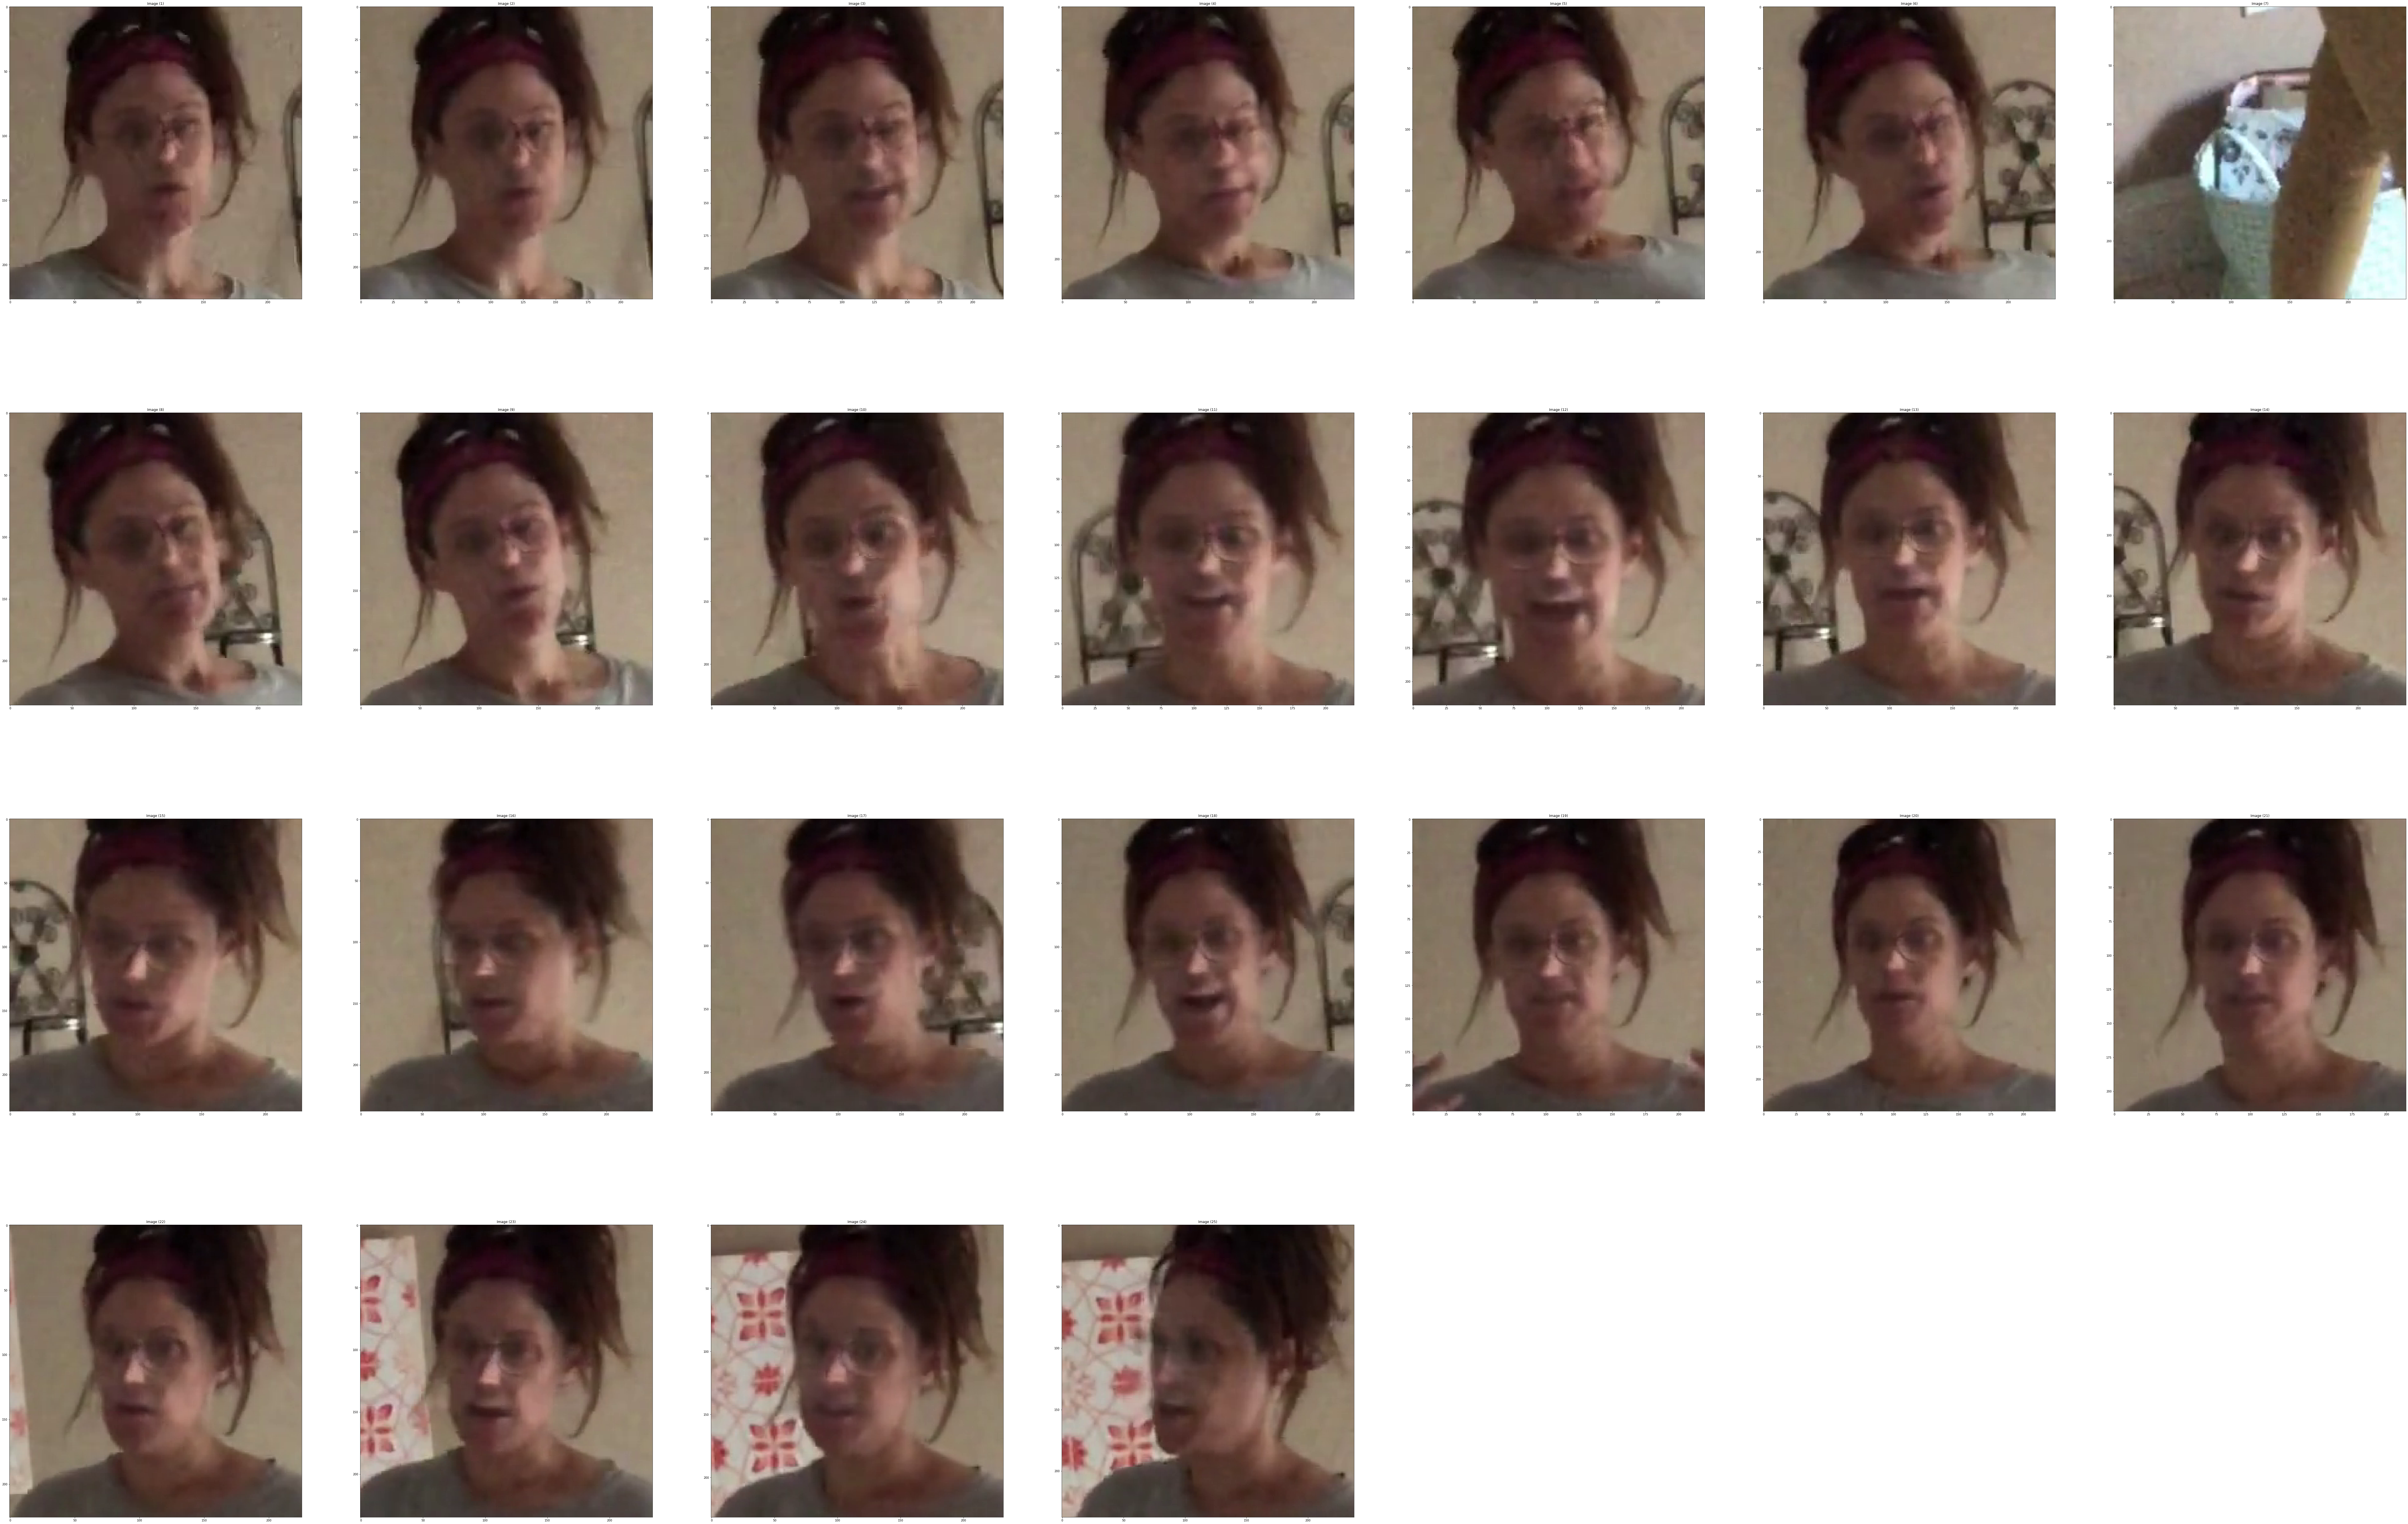

CPU times: user 31.7 s, sys: 1.05 s, total: 32.7 s
Wall time: 8.13 s


In [33]:
%%time
i += 1

num_frames = 24
out = []
avg_size = 0
avg_score = 0

label = get_text_label(i, df)
print('%d: %s' % (i, label))

sample = get_sample(i, df, reader, n_frames=num_frames)
dets = detect(sample, net, cfg, device)

for f in range(num_frames):
    num_faces = len(dets[f])
    
    if num_faces == 0:
        print(f'No faces in {f} frame')
    elif num_faces > 1:
        print(f'{num_faces} faces in {f} frame with probs:')
        scores = [d[-1] for d in dets[f]]
        print(scores)
        
    for det in dets[f]:
        cropped = crop_face(sample[f], det[:4])
        out.append(cropped)
        avg_size += cropped.shape[0]
        avg_score += det[4] / num_faces
        
avg_size /= num_frames
avg_score /= num_frames
print('Avg size: %.1f' % avg_size)
print('Avg score: %.3f' % avg_score)
cols = math.ceil(len(dets) / 6)
show_images(out, cols=cols)

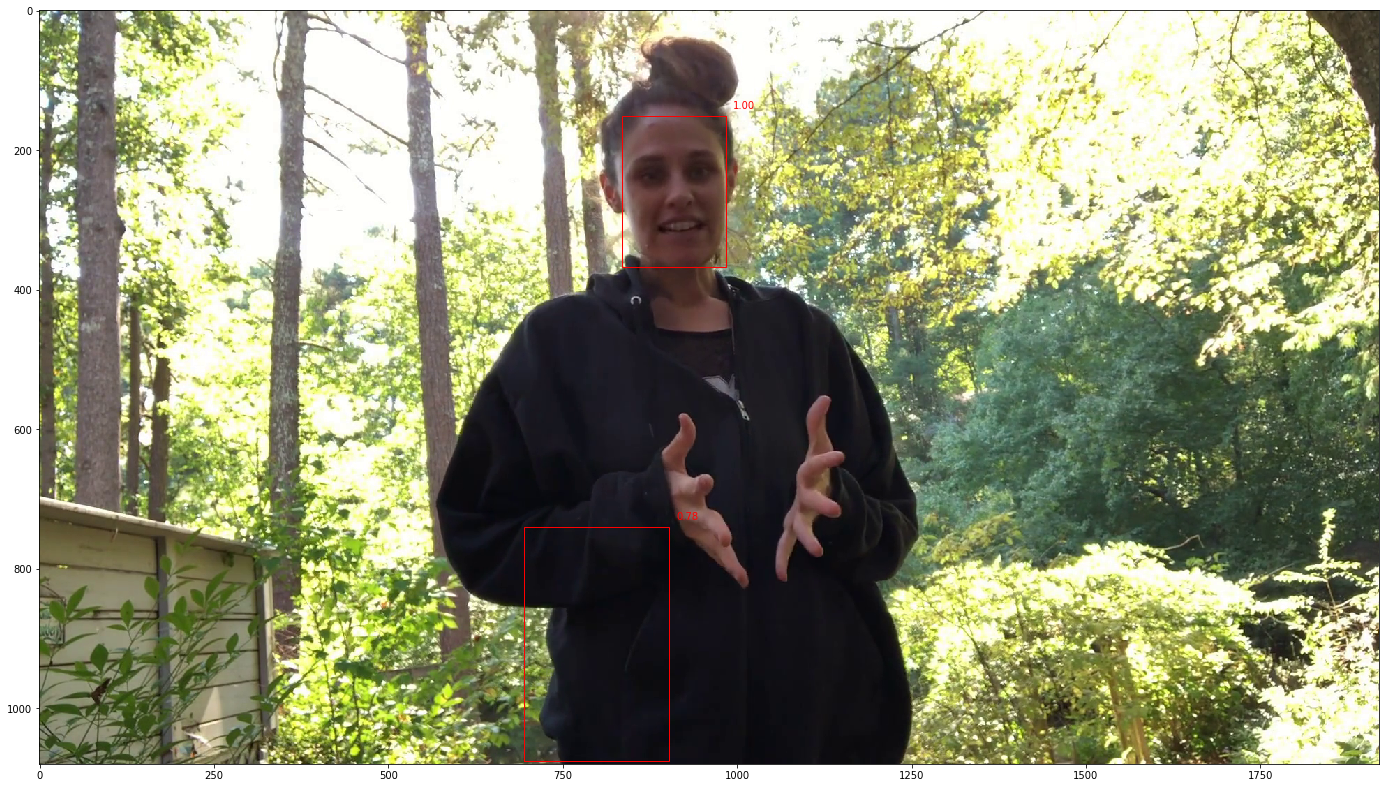

In [32]:
f = 17
show_image_bbox(sample[f], boxes=dets[f], figsize=(24, 24))